## LandTrendr Implementation For Decadal Averaging of Spectral Indices

# Requirements: 

Python:

* geemap
* ee
* matplotlib
* numpy
* pandas
* oeel ** 

Other:
* Google Earth Engine Account

The LandTrendr algorithm is highly efficient and extensive tool with documentation at this link: https://emapr.github.io/LT-GEE/

This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2

** this package allows the user to run GEE modules directly without the pitfalls of translating JS to Python.

In [2]:
#%config IPCompleter.use_jedi = False

import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

### save the date as a variable to use for version control

In [3]:
today = dt.today()
print("Today is: ", today)

Today is:  2023-03-15 12:15:34.070900


 # GEE Authentication
 
 - The ee.authenticate line is necessary the first time using ee (and roughly every week thereafter)
 - Authentication requires the user to log into their Earth Engine account which will provide the opportunity to copy and paste an a personal authentication code to this notebook granting access to the server. 
 - Authentication lasts for roughly one week, whereupon the "token required" error on the subsequent "ee.initialize" cell will signal the need to re-do the authentication step.
 - Simply comment and un-comment the ee.authenticate cell below when required
 
 
 ### Paste the Authetication code into the box below. 
 
 (press enter to save token, comment out this box until prompted again )


In [4]:
#ee.Authenticate()

In [5]:
geemap.ee_initialize()

Enter verification code:  4/1AWtgzh4hLJEgocjvdyrBn-9C1EgF5YVDIAuDK52uhWz2yfborEMG1P0KxPM



Successfully saved authorization token.


### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available

In [9]:
p = '..'


l_BE = pd.read_csv(f"{p}\Inputs\Version_3_20230303\BE.csv").catchment.tolist()
l_FR = pd.read_csv(f"{p}\Inputs\Version_3_20230303\FR.csv").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter for a space and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i


names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')

22 catchments processed for hydroclimatic variables:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Ã‰lophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']



### Load the EE package

The landTrendr package is developed to construct timeseries of landsat imagery for the purpose of land cover detection. The base parameters are optimised for deforestation event detection. 

This utilisation of the GEE asset (with apache license i.e. free for use) allows for the latest version of LandTrendr to be used. In contrast to early versions this allows for the utilisation of the Landsat Collection 2 reprocessing effort with improvements in cloud masking capabilities. Primarily we use "ltgee.buildSRcollection"

If the JS module is faulty then the cell below will not load. 

In [10]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v6.js')
#ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v5.js')

ltgee.availability  #all functions within the javascript module


{'version': 'string',
 'buildSensorYearCollection': 'function',
 'getSRcollection': 'function',
 'getCombinedSRcollection': 'function',
 'buildSRcollection': 'function',
 'getCollectionIDlist': 'function',
 'countClearViewPixels': 'function',
 'buildClearPixelCountCollection': 'function',
 'removeImages': 'function',
 'LAIcol': 'function',
 'calcIndex': 'function',
 'standardize': 'function',
 'transformSRcollection': 'function',
 'createTrainingImage': 'function',
 'addTerrainBand': 'function',
 'genGCP': 'function',
 'classifier': 'function',
 'classArea': 'function'}

## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository


In [11]:
asset_dir = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW'

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

In [12]:
startYear = 1984

endYear = 2022

startDay = '06-20'

endDay = '08-31'

maskThese = ['cloud', 'shadow', 'snow',]

bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 


## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- The area is calculated of each shape and ranked per area, assuming that the largest is the most computationally expensive
- This is done so that we can iterate from smallest to largest, or the opposite, should any memory issues become apparent.

In [13]:
table = ee.FeatureCollection(f"projects/mohanrahan/assets/{asset_dir}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':'EPSG:4326',
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)


Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

df1 = down.loc[down['Stations_M'].isin(names)]

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]


,pixel_area,area_km2,Stations_3,Stations_2,Stations_1,long_cntrd,lat_cntrd,Stations_M
system_index,,,,,,,,
00000000000000000018,1589.533689,1584.214049,50.092133,4.806526,Chooz,4.867246,49.774258,Chooz
0000000000000000001d,1372.050234,1367.694860,49.493890,5.177972,La Meuse Stenay,5.344417,49.164286,La Meuse Stenay
0000000000000000001e,1347.055442,1342.927162,48.870879,5.530998,La Meuse Saint-Mihiel,5.666623,48.556343,La Meuse Saint-Mihiel
0000000000000000000d,1306.148656,1301.658056,50.536477,5.317771,Amay,4.984290,50.334882,Amay
0000000000000000001b,973.084708,969.907519,49.629141,5.159217,La Chiers Carignan,5.505163,49.491089,La Chiers Carignan
00000000000000000012,907.666741,904.622343,49.863767,4.902010,Membre Pont,5.297871,49.792315,Membre Pont
0000000000000000000e,548.303165,546.432054,50.088626,4.675975,Treignes,4.467033,50.045699,Treignes
00000000000000000019,405.813979,404.503520,49.660450,4.882686,La Bar Cheveuges,4.834297,49.541173,La Bar Cheveuges
00000000000000000020,403.736681,402.538982,48.317100,5.710398,Le Mouzon Circourt-sur-Mouzon [Villars],5.749710,48.173441,Le Mouzon Circourt-sur-Mouzon [Villars]


pixel_area                   123.21842
area_km2                    122.802489
Stations_3                    49.72767
Stations_2                    4.714185
Stations_1    La Vence la Francheville
long_cntrd                    4.615253
lat_cntrd                     49.67204
Stations_M    La Vence la Francheville
Name: 00000000000000000015, dtype: object

In [14]:
gdf = geemap.ee_to_pandas(Filtered_Sorted)

if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx')

In [15]:
Map.addLayer(Filtered_Sorted, {}, 'table')
Map.centerObject(Filtered_Sorted, 7)

Map

Map(center=[49.771185229680235, 5.34768540569512], controls=(WidgetControl(options=['position', 'transparent_b…

In [16]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def image_band_mean(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.mean(),
    'region': aoi,
    'scale': scale,
    'band': band+'_mean',
    })
    
    return chart_ts_region.dataframe

def image_band_median(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': band+'_median',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_5(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([5]),
    'region': aoi,
    'scale': scale,
    'band': band+'_p5',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_95(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([95]),
    'region': aoi,
    'scale': scale,
    'band': band+'_p95',
    })
    
    return chart_ts_region.dataframe

    
def bands_reduced_toexcel(imcol, scale, ind, band):
    '''
    Takes the bands and returns excel sheets of each catchment:
    ->mean, median, percentile, 
    '''
    df_mean = image_band_mean(imcol, scale, band)
    df_median = image_band_median(imcol, scale, band)
    df_pct5 = image_band_percentile_5(imcol, scale, band)
    df_pct95 = image_band_percentile_95(imcol, scale, band)
    
    
    df_mean.reset_index()
    df_median.reset_index()
    df_pct5.reset_index()
    df_pct95.reset_index()
    
    
    joined= df_mean.join(df_median, how='inner', lsuffix='mean', rsuffix='median')
    joined_pct = df_pct5.join(df_pct95, how='inner', lsuffix='p5', rsuffix='p95')
   
    annual = joined.join(joined_pct, how='inner')
    annual.to_excel(f'../Outputs/{dataset}/timeseries/{ind}_annual_{band}.xlsx')

def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds):
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i, yc, classified, trainingClassImage, ms, classImageYear, name, accuracy, pixArea):

    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pixArea
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted

def normalize (image):
    '''
    This function is used to convert band values to a range between 0 and 1 via normalisation,
    this is typically slow and no improvement to accuracy has been observed yet by its implementation.
    
    The 5 minute loop for an example catchment e.g. Chooz 2012, goes from 
    '''
    bandNames = image.bandNames()
    
def saveClassifierToCSV(classifier, name, yc):
    decisionTrees = ee.List(classifier.explain().get('trees')).getInfo()
    folder='Trees'

    var = f'../Outputs/{dataset}/{folder}/'

    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

    ml.trees_to_csv(decisionTrees, f'../Outputs/Meuse/Trees/{name}_{yc}')

## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [14]:
scale = 1000 # define the pixel size for reducing, in meters, initially high to reduce comp time


id_ls = 'used_images'
SR_t = 'SR_timeseries'
RF_c = 'RF_classification/'


folder_list = [id_ls, SR_t, RF_c]

for folder in folder_list:
    
    var = f'../Outputs/{dataset}/{folder}'
    
    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

c_1990 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_1990')
c_2000 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2000')
c_2006 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2006')
c_2012 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2012')
c_2018 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2018')

The loop goes through all shapes in the WFLOW derived catchment list maximising data collection and also stress testing the workflow for memory exceedences
The classification scheme is run at the same time as the surface reflectance data gathering

17:06:39.102404 ,  cancelled after 14 mins...
remove the classify function and rerun


In [1]:
'''
Tuning of hyperParameters 'rfParams' is accomplished using this link:

https://code.earthengine.google.com/fb0850cf3a8712cef6da822186fb2be1

JSON printed in the console was plotted in python to find the optimal parameters for 
this purpose. Specifically two years were plotted for the Chooz catchment 1990 vs 2018.

The optimal parameter for each year was identified using overall accuaracy and overall kappa score
Optimal parameter set for all years was determined to be between each.

The parameters are hard coded into the JS module:

Number of trees = 190
Varibles per split = 9
Minimum leaf population = 18
Bag fraction =  0.7
Max nodes = 400
Seed = 0

This results in an accuracy ranging from 84-86% max over the years

'''

classLoopParams = {'dataset':'CORINE', 
               'trainingClassLevel':1,
               'customClassLevels':None,
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':10,            #tileScale higher number reduces likelihood of classifier running into a memory limit
              }

In [ ]:
t0 = dt.today()

classArea_df = pd.DataFrame()

#sys_index = ['0000000000000000000e'] #Treignes
#sys_index = ['00000000000000000018']


print(f'begin loop: {t0}')

for i, ind in enumerate(sys_index):
    '''
    TODO: add Kappa, producers and consumers accuracy to the return
    
    '''
    
    name = df1.loc[ind].Stations_M
    
    area = df1.loc[ind].area_km2
    
    pix_area = df1.loc[ind].pixel_area
    
    t1 = dt.today()
    
    print(f'\n{i+1}/{len(sys_index)} {t1}\nDataset: {dataset}, \nCatchment: {name}, \nSurface Reflectance Processing ...\n')
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, ['slcOff'])
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    band_calc_df = bands_reduced_toexcel(ee.ImageCollection(annual_med_calc), scale, ind, 'B1')
    
    col = ee.ImageCollection(ltgee.LAIcol(startYear, endYear, startDay, endDay, aoi)) 
    
    lai_calc_df = bands_reduced_toexcel(col, col.first().projection().nominalScale().getInfo(), ind, 'LAI')
    
    '''
    
    Which images are used in creating the annual composites?
    -> return as a list of Landsat image IDs ** 
    ** can be used for exclusion if image quality is suboptimal upon later inspection.. important for small sample cases.
    
    '''
    
    id_key = 'idList'
    
    masked_col_key = 'collection'
    
    GetCollectionID = ltgee.getCollectionIDlist(startYear, endYear, startDay, endDay, aoi)
    
    im_id_list = GetCollectionID[id_key]
    
    image_list = pd.DataFrame({f'{name}': im_id_list.getInfo()})
    
    image_list.to_csv(f'../Outputs/{dataset}/used_images/{ind}_imageList.csv')
    
    
    t2 = dt.today()
    
    print(f'step 1: Surface reflectance exported: {t2} \nTime taken: {t2-t1}')
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        year_classified = np.arange(1984, 2018)
        # year_classified = [2012]#,2012]#, 2018]    #[1990, 2000, 2006, 
        
        for j, yc in enumerate(year_classified):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            if yc >= 1984 and yc < 1999:
                classifier = c_1990
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classifier = c_2000
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classifier = c_2006
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classifier = c_2012
                classImageYear = 2012

            elif yc >= 2015:
                classifier = c_2018
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first().clip(aoi)
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), classLoopParams['dataset'], classLoopParams['trainingClassLevel'], aoi)
            
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(imageFromCollection, aoi)
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, imageToClassify, classLoopParams['numClasses'], classLoopParams['split'], classLoopParams['tileScale'], aoi, 'weighted')
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            # classifier training with predefined number of trees using training points
            classifier = ltgee.classifier(imageToClassify, training)
            
            t6 = dt.today()
            
            #saving decision trees for later use
            # saveClassifierToCSV(classifier, name, yc)
            
#             #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            focal = classified.focalMode(**{'radius':30,
                                          'kernelType':'square',
                                          'units':'meters',
                                          'iterations':2}).clip(aoi)
            
            Map.addLayer(focal, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}, f'{name} RF:{j}.{yc}.{classImageYear}')
#             #assess the accuracy using the testing points, see where the confusion occurs
            EM = testing.classify(classifier).errorMatrix('landcover', 'classification').accuracy()
            accuracy = .getInfo()
            kappa = 
            print(f'{yc} classified using: {classImageYear} ...  \naccuracy: {accuracy:.3f}')


            df = dataframeAreas(i, j, focal, trainingClassImage, ms, classImageYear, name, accuracy, pix_area)
            
#             df.to_csv(f'../Outputs/{dataset}/RF_classification/{ind}_classes.csv')
            
            classArea_df = classArea_df.append(df)
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    if ind == sys_index[0]:
        break



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-03-14 19:34:08.955539

1/20 2023-03-14 19:34:08.958514
Dataset: Meuse, 
Catchment: Chooz, 
Surface Reflectance Processing ...

step 1: Surface reflectance exported: 2023-03-14 19:34:40.428832 
Time taken: 0:00:31.470318

step 2: Initialize classification routine: 2023-03-14 19:34:40.428832
1984 classified using: 1990 ...  
accuracy: 0.825
1985 classified using: 1990 ...  
accuracy: 0.831


In [20]:
print(classArea_df.iloc[0, 0:5].sum())
print(classArea_df.iloc[0, 5:10].sum())

NameError: name 'classArea_df' is not defined

In [18]:
classArea_df.to_excel('all_class.xlsx')

In [81]:
ee.ImageCollection(annual_med_calc).first().projection().getInfo()['crs']

'EPSG:4326'

In [64]:
classArea_df.keys()

MultiIndex([('area_CORINE',            '1'),
            ('area_CORINE',            '2'),
            ('area_CORINE',            '3'),
            ('area_CORINE',            '4'),
            ('area_CORINE',            '5'),
            (    'area_RF',            '1'),
            (    'area_RF',            '2'),
            (    'area_RF',            '3'),
            (    'area_RF',            '4'),
            (    'area_RF',            '5'),
            (   'training', 'year_trained'),
            ('area_CORINE',            '6'),
            (  'catchment',         'area'),
            (    'area_RF',            '6'),
            (  'catchment',        'name '),
            (    'testing',     'accuracy'),
            (        'ind',             '')],
           names=[None, 'class'])

In [326]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']

rdx = classArea_df.reset_index().fillna(0)
for i in range(6):
    print(class_name[i], np.mean(rdx.area_CORINE.iloc[:,i]/rdx.catchment.area))

rdx

Artificial 0.06870930154647932
Agricultural 0.5564000830756927
Forest and Semi-Natural 0.37262993599826644
Wetlands 0.0006041072924014751
Waterbodies 0.0016565720870619905
Masked 0.0


image_date area_CORINE                                    \
class                               1           2           3         4   
0     1984-08-31 22:00:00   93.132199  616.996084  859.204607  2.005247   
1     1985-08-31 22:00:00   93.132199  616.996084  859.204607  2.005247   
2     1986-08-31 22:00:00   93.132199  616.996084  859.204607  2.005247   
3     1987-08-31 22:00:00   93.132199  616.996084  859.204607  2.005247   
4     1988-08-31 22:00:00   93.132199  616.996084  859.204607  2.005247   
..                    ...         ...         ...         ...       ...   
675   2013-08-31 22:00:00    4.279954   86.793746   32.144720  0.000000   
676   2014-08-31 22:00:00    4.279954   86.793746   32.144720  0.000000   
677   2015-08-31 22:00:00    4.279954   86.793746   32.144720  0.000000   
678   2016-08-31 22:00:00    4.279954   86.793746   32.144720  0.000000   
679   2017-08-31 22:00:00    4.279954   86.793746   32.144720  0.000000   

                     area_RF                                                 \
class          5           1           2           3           4          5   
0      18.195552  143.821862  761.311636  617.608210   23.197824  43.594157   
1      18.195552  120.027906  501.481779  768.769516  151.605652  47.629616   
2      18.195552   99.531703  543.702801  808.725583   85.135957  50.583150   
3      18.195552   98.755023  484.434977  751.428947  200.473084  54.441658   
4      18.195552  119.520072  499.759008  777.750042  138.943248  53.231420   
..           ...         ...         ...         ...         ...        ...   
675     0.000000   36.578097   74.076531    3.444054    0.000000   0.000000   
676     0.000000   23.800755   90.972975    1.397228    0.000000   0.000000   
677     0.000000   21.024090   72.498012   25.525850    0.000000   0.000000   
678     0.000000    9.092851   71.097675   33.859090    0.000000   0.000000   
679     0.000000   14.528929   71.514823   26.762581    0.000000   0.000000   

          training area_CORINE    catchment       area_RF  \
class year_trained           6         area             6   
0             1990           0  1589.533689 -1.016360e-10   
1             1990           0  1589.533689  1.921990e-02   
2             1990           0  1589.533689  1.854494e+00   
3             1990           0  1589.533689 -1.066383e-10   
4             1990           0  1589.533689  3.298984e-01   
..             ...         ...          ...           ...   
675           2012           0   123.218420 -2.015444e+03   
676           2012           0   123.218420 -2.013397e+03   
677           2018           0   123.218420 -2.043526e+03   
678           2018           0   123.218420 -2.051859e+03   
679           2018           0   123.218420 -2.044763e+03   

                      catchment   testing    ind  
class                     name   accuracy         
0                         Chooz  0.632558    0_0  
1                         Chooz  0.703457    0_1  
2                         Chooz  0.681063    0_2  
3                         Chooz  0.710299    0_3  
4                         Chooz  0.744016    0_4  
..                          ...       ...    ...  
675    La Vence la Francheville  0.497175  19_29  
676    La Vence la Francheville  0.455367  19_30  
677    La Vence la Francheville  0.667063  19_31  
678    La Vence la Francheville  0.642093  19_32  
679    La Vence la Francheville  0.594530  19_33  

[680 rows x 18 columns]

In [300]:
rdx.area_RF.iloc[:, -1].sum()

-1124855.0260708863

In [328]:
rdx = classArea_df.reset_index().fillna(0)
# rdx.area_RF.iloc[:, 5] = rdx.area_RF.iloc[:,0:4].sum(axis=1) - rdx.catchment.area
rdx[('area_RF', 'masked')] = rdx.area_RF.iloc[:,0:5].sum(axis=1) - rdx.catchment.area

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

print('Fixed Mask', np.mean(rdx.area_RF.masked/rdx.catchment.area))


Artificial 0.11721485045595495
Agricultural 0.4381846659628328
Forest and Semi-Natural 0.31387029724051535
Wetlands 0.024108651280275794
Waterbodies 0.009823842613799885
Masked -6.39658873038874
Fixed Mask -0.09679769244662123


In [329]:
grouped = rdx.groupby('image_date').sum()
grouped

area_CORINE                                      \
class                         1            2            3         4   
image_date                                                            
1984-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1985-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1986-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1987-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1988-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1989-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1990-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1991-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1992-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1993-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1994-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1995-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1996-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1997-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1998-08-31 22:00:00  698.410243  5841.908532  4792.463638  7.294967   
1999-08-31 22:00:00  710.560698  5826.786970  4794.571113  4.830439   
2000-08-31 22:00:00  710.560698  5826.786970  4794.571113  4.830439   
2001-08-31 22:00:00  710.560698  5826.786970  4794.571113  4.830439   
2002-08-31 22:00:00  710.560698  5826.786970  4794.571113  4.830439   
2003-08-31 22:00:00  710.560698  5826.786970  4794.571113  4.830439   
2004-08-31 22:00:00  731.589674  5813.947816  4785.217938  4.853040   
2005-08-31 22:00:00  731.589674  5813.947816  4785.217938  4.853040   
2006-08-31 22:00:00  731.589674  5813.947816  4785.217938  4.853040   
2007-08-31 22:00:00  731.589674  5813.947816  4785.217938  4.853040   
2008-08-31 22:00:00  731.589674  5813.947816  4785.217938  4.853040   
2009-08-31 22:00:00  731.589674  5813.947816  4785.217938  4.853040   
2010-08-31 22:00:00  763.288592  5780.186976  4783.816369  6.312169   
2011-08-31 22:00:00  763.288592  5780.186976  4783.816369  6.312169   
2012-08-31 22:00:00  763.288592  5780.186976  4783.816369  6.312169   
2013-08-31 22:00:00  763.288592  5780.186976  4783.816369  6.312169   
2014-08-31 22:00:00  763.288592  5780.186976  4783.816369  6.312169   
2015-08-31 22:00:00  769.496416  5775.004992  4782.425345  6.312169   
2016-08-31 22:00:00  769.496416  5775.004992  4782.425345  6.312169   
2017-08-31 22:00:00  769.496416  5775.004992  4782.425345  6.312169   

                                    area_RF                            \
class                        5            1            2            3   
image_date                                                              
1984-08-31 22:00:00  36.352134   984.091734  6549.021876  3418.116486   
1985-08-31 22:00:00  36.352134   818.066888  4528.534221  4401.006980   
1986-08-31 22:00:00  36.352134   550.087619  4972.548070  5035.453956   
1987-08-31 22:00:00  36.352134   567.728690  4898.051884  4554.685387   
1988-08-31 22:00:00  36.352134   865.617348  4875.700874  4499.521749   
1989-08-31 22:00:00  36.352134   994.154831  4575.014652  4422.825994   
1990-08-31 22:00:00  36.352134   959.513116  5252.631541  4395.741904   
1991-08-31 22:00:00  36.352134   711.628494  4887.759553  4369.085311   
1992-08-31 22:00:00  36.352134   991.413419  5305.368466  3761.970636   
1993-08-31 22:00:00  36.352134   624.756569  3510.200823  2572.074904   
1994-08-31 22:00:00  36.352134   957.868772  3194.458416  3845.832129   
1995-08-31 22:00:00  36.352134   679.772173  3333.307875  5165.512925   
1996-08-31 22:00:00  36.352134   663.295545  2732.351419  4417.836620   
1997-08-31 22:00:00  36.352134   660.360423  3887.675405  4597.926625   
1998-08-31 22:00:00  36.352134   783.228646  3682.058304  3868.753430   
1999-08-31 22:00:00  39.680294   941.418510  4950.117626  4407.604711   
2000-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


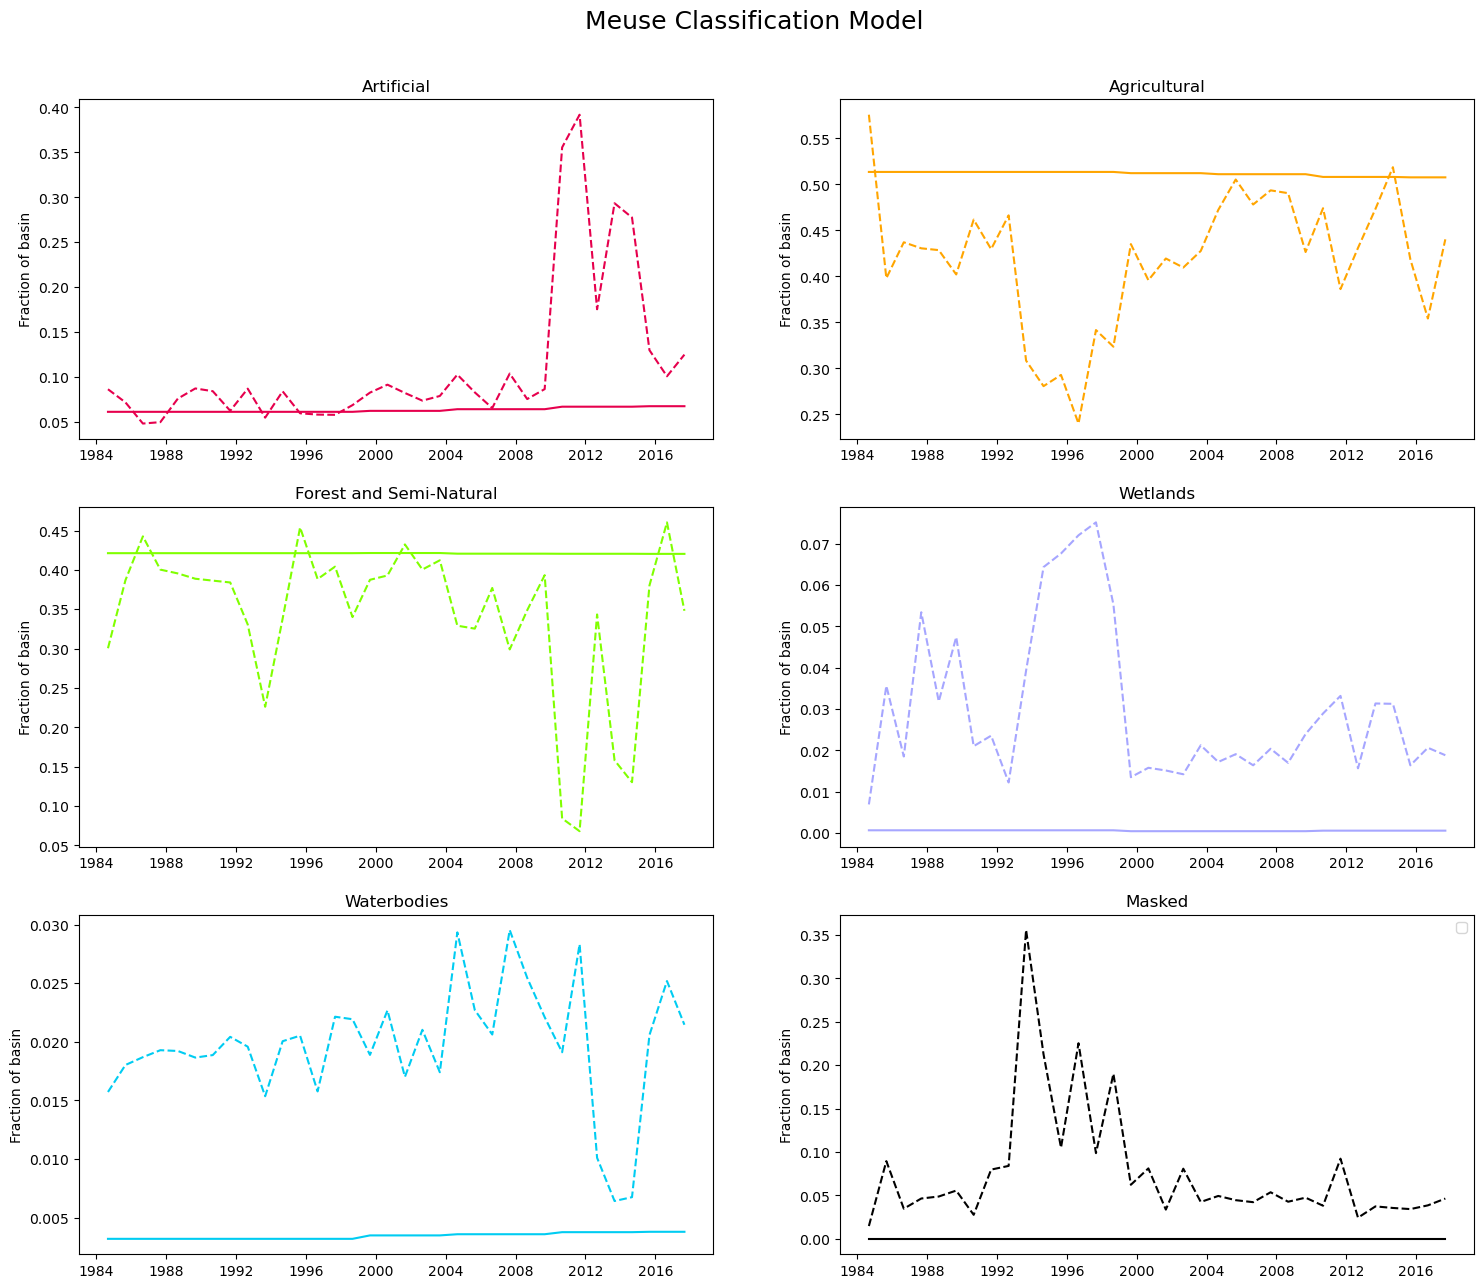

In [364]:
grouped = rdx.groupby('image_date').sum()

colors = ['#E6004D', 'orange', '#80FF00', '#A6A6FF', '#00CCF2', 'black']

fig, axes = plt.subplots(3,2, figsize = (18,15))

tit = plt.suptitle('Meuse Classification Model', y=0.94, size=18)

for i in range(6):
    if i == 0:
        col=0
        row=0
    elif i==1:
        col=1
        row=0
    elif i==2:
        col=0
        row=1
    elif i==3:
        col=1
        row=1
    elif i==4:
        col=0
        row=2
    elif i==5:
        col=1
        row=2
    
    if i<5:
        ax = axes[row, col]
        ax.set_title(class_name[i])
        ax.plot(grouped.area_RF.iloc[:,i]/grouped.catchment.area,linestyle='dashed', c=colors[i], label=f'{class_name[i]} modelled')
        ax.plot(grouped.area_CORINE.iloc[:,i]/grouped.catchment.area, c=colors[i], label=f'{class_name[i]} corine')
        ax.set_ylabel('Fraction of basin')
        plt.legend()
    
    if i==5:
        col=1
        row=2
        ax = axes[row, col]
        ax.set_title(class_name[i])
        ax.plot(grouped.area_RF.masked.abs()/grouped.catchment.area, linestyle='dashed', c=colors[i], label= f'')
        ax.plot(grouped.area_CORINE.iloc[:,i]/grouped.catchment.area, c=colors[i])
        ax.set_ylabel('Fraction of basin')



AttributeError: 'Text' object has no attribute 'Text'

In [226]:
df = image_band_percentile_95(ee.ImageCollection(annual_med_calc), 10000)

In [ ]:
classArea_df = pd.read_excel('../Outputs/meuse/RF_classification/classifier_search.xlsx', header=[0,1], index_col=0, parse_dates=True)
classArea_df.keys()

In [ ]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    classArea_df.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [ ]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

In [ ]:

fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.set_ylim(0.6, 0.9)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

In [ ]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

1589.5336892619698

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map